In this Notebook, we will use 15k images to train a basic model and try different method to improve its accuracy.

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import math

print(tf.__version__)


2025-11-11 20:44:40.275270: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-11 20:44:40.275384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-11 20:44:40.277714: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.1


In [2]:
# Dataset paths
BASE_DIR = "../datasets"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")

# Image & training settings
IMG_SIZE    = (128, 128)
BATCH_SIZE  = 32
SEED        = 42

# Use ~15k images: 480 * 32 = 15360
TRAIN_BATCH_LIMIT = 480
EPOCHS = 10


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

# 1) Load full training dataset (shuffled)
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

# 2) Load full validation dataset (no shuffle)
val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds_raw.class_names
print("Classes:", class_names)

# Limit training data to ~15k images via batches
train_ds_limited_raw = train_ds_raw.take(TRAIN_BATCH_LIMIT)

# Simple normalize function
def normalize_images(x, y):
    return tf.cast(x, tf.float32) / 255.0, y

# Base input pipeline (no augmentation)
train_ds_15k = (
    train_ds_limited_raw
    .map(normalize_images, num_parallel_calls=AUTOTUNE)
    .cache("./train_cache.tfdata")
    .shuffle(200, seed=SEED)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds_raw
    .map(normalize_images, num_parallel_calls=AUTOTUNE)
    .cache("./val_cache.tfdata")
    .prefetch(AUTOTUNE)
)

# Rough count
num_train_batches = tf.data.experimental.cardinality(train_ds_limited_raw).numpy()
num_val_batches   = tf.data.experimental.cardinality(val_ds_raw).numpy()

print(f"Train batches (limited): {num_train_batches}, approx {num_train_batches * BATCH_SIZE} images")
print(f"Val batches: {num_val_batches}, approx {num_val_batches * BATCH_SIZE} images")


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Classes: ['cat', 'dog']
Train batches (limited): 480, approx 15360 images
Val batches: 157, approx 5024 images


In [8]:
def build_baseline_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',                      # default lr = 0.001
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

baseline_model = build_baseline_model()
baseline_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 128)      

In [9]:
dummy = build_baseline_model()
dummy.fit(train_ds_15k.take(2), epochs=1)


2/2 [==============================] - 27s 175ms/step - loss: 0.7999 - accuracy: 0.4688


In [10]:
history_baseline = baseline_model.fit(
    train_ds_15k,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

baseline_best_val = max(history_baseline.history['val_accuracy'])
print(f"Baseline best val accuracy: {baseline_best_val:.4f}")


Epoch 1/10
480/480 [==============================] - 78s 108ms/step - loss: 0.6226 - accuracy: 0.6361 - val_loss: 0.5666 - val_accuracy: 0.7024
Epoch 2/10
480/480 [==============================] - 33s 46ms/step - loss: 0.4987 - accuracy: 0.7563 - val_loss: 0.4512 - val_accuracy: 0.7910
Epoch 3/10
480/480 [==============================] - 37s 59ms/step - loss: 0.4142 - accuracy: 0.8106 - val_loss: 0.4675 - val_accuracy: 0.7814
Epoch 4/10
480/480 [==============================] - 40s 56ms/step - loss: 0.3626 - accuracy: 0.8379 - val_loss: 0.4645 - val_accuracy: 0.7882
Epoch 5/10
480/480 [==============================] - 35s 53ms/step - loss: 0.3049 - accuracy: 0.8684 - val_loss: 0.3957 - val_accuracy: 0.8288
Epoch 6/10
480/480 [==============================] - 33s 50ms/step - loss: 0.2500 - accuracy: 0.8973 - val_loss: 0.4061 - val_accuracy: 0.8332
Epoch 7/10
480/480 [==============================] - 33s 48ms/step - loss: 0.1935 - accuracy: 0.9212 - val_loss: 0.3899 - val_accuracy

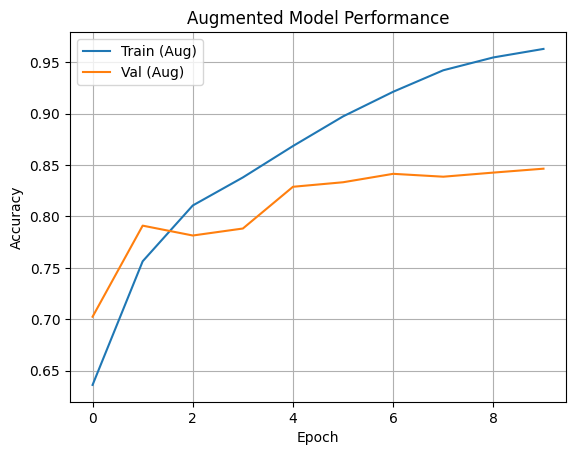

In [28]:
plt.plot(history_baseline.history['accuracy'], label='Train (Aug)')
plt.plot(history_baseline.history['val_accuracy'], label='Val (Aug)')
plt.legend()
plt.title("Augmented Model Performance")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


In [13]:
os.makedirs("../deeplearning/models", exist_ok=True)
baseline_model.save("../deeplearning/models/cnn_baseline_15k.keras")
print("✅ Model saved successfully!")


✅ Model saved successfully!


### 1. Improve by image agumentation

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),    # flips left-right (cats/dogs)
    layers.RandomRotation(0.1),         # slight rotations
    layers.RandomZoom(0.1),             # zoom in/out
    layers.RandomContrast(0.1)          # adjust brightness/contrast
], name="data_augmentation")

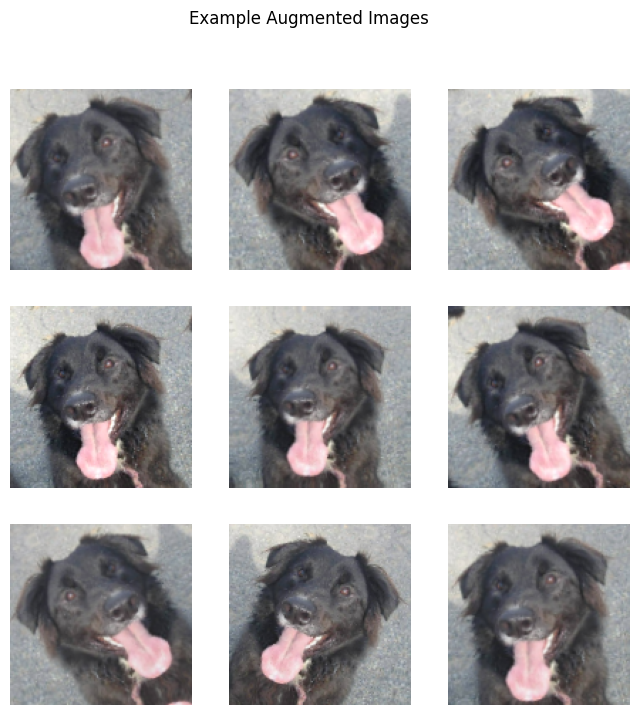

In [ ]:
# quick visualization
for images, _ in train_ds_raw.take(1):
    plt.figure(figsize=(8, 8))
    for i in range(9):
        augmented = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented[0].numpy().astype("uint8"))
        plt.axis("off")
    break
plt.suptitle("Example Augmented Images")
plt.show()


In [25]:
def build_aug_model():
    model = models.Sequential([
        layers.Input(shape=(*IMG_SIZE, 3)),          # <-- explicitly define input
        data_augmentation,                            # <- augmentation first

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',  # same default lr = 0.001
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

aug_model = build_aug_model()
aug_model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 128, 128, 3)       0         
 ial)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                      

In [26]:
history_aug = aug_model.fit(
    train_ds_15k,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

aug_best_val = max(history_aug.history['val_accuracy'])
print(f"Baseline best val accuracy: {aug_best_val:.4f}")


Epoch 1/10


480/480 [==============================] - 37s 56ms/step - loss: 0.6657 - accuracy: 0.5978 - val_loss: 0.6274 - val_accuracy: 0.6496
Epoch 2/10
480/480 [==============================] - 37s 54ms/step - loss: 0.5889 - accuracy: 0.6885 - val_loss: 0.5379 - val_accuracy: 0.7262
Epoch 3/10
480/480 [==============================] - 33s 50ms/step - loss: 0.5418 - accuracy: 0.7303 - val_loss: 0.4887 - val_accuracy: 0.7650
Epoch 4/10
480/480 [==============================] - 36s 56ms/step - loss: 0.5073 - accuracy: 0.7563 - val_loss: 0.4708 - val_accuracy: 0.7778
Epoch 5/10
480/480 [==============================] - 33s 50ms/step - loss: 0.4831 - accuracy: 0.7730 - val_loss: 0.4806 - val_accuracy: 0.7680
Epoch 6/10
480/480 [==============================] - 34s 52ms/step - loss: 0.4577 - accuracy: 0.7886 - val_loss: 0.4164 - val_accuracy: 0.8028
Epoch 7/10
480/480 [==============================] - 32s 47ms/step - loss: 0.4370 - accuracy: 0.8014 - val_loss: 0.4034 - val_accuracy: 0.8104
Epo

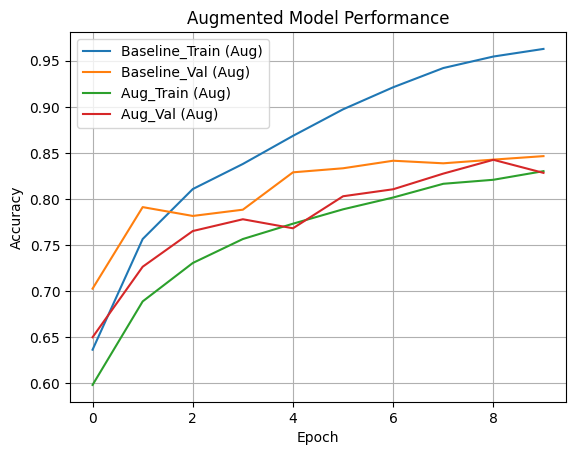

In [29]:
plt.plot(history_baseline.history['accuracy'], label='Baseline_Train (Aug)')
plt.plot(history_baseline.history['val_accuracy'], label='Baseline_Val (Aug)')

plt.plot(history_aug.history['accuracy'], label='Aug_Train (Aug)')
plt.plot(history_aug.history['val_accuracy'], label='Aug_Val (Aug)')
plt.legend()
plt.title("Augmented Model Performance")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()


We notice that the accuracy droped, this maybe due to:
1. slower learning due to agumentation
2. model is underfit due to high dropout (we will not change dataset size at this stage)
Thus, we increase epoches to 15 and decrease dropout to 0.3

In [30]:
def build_aug_model2():
    model = models.Sequential([
        layers.Input(shape=(*IMG_SIZE, 3)),          # <-- explicitly define input
        data_augmentation,                            # <- augmentation first

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',  # same default lr = 0.001
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

aug_model2 = build_aug_model2()
aug_model2.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 128, 128, 3)       0         
 ial)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                     

In [33]:
EPOCHS = 15
history_aug2 = aug_model2.fit(
    train_ds_15k,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

aug_best_val2 = max(history_aug2.history['val_accuracy'])
print(f"Baseline best val accuracy: {aug_best_val2:.4f}")


Epoch 1/15


480/480 [==============================] - 43s 62ms/step - loss: 0.6857 - accuracy: 0.5417 - val_loss: 0.6695 - val_accuracy: 0.5576
Epoch 2/15
480/480 [==============================] - 43s 60ms/step - loss: 0.6203 - accuracy: 0.6576 - val_loss: 0.5605 - val_accuracy: 0.7096
Epoch 3/15
480/480 [==============================] - 41s 61ms/step - loss: 0.5595 - accuracy: 0.7180 - val_loss: 0.5138 - val_accuracy: 0.7424
Epoch 4/15
480/480 [==============================] - 40s 61ms/step - loss: 0.5248 - accuracy: 0.7417 - val_loss: 0.4725 - val_accuracy: 0.7662
Epoch 5/15
480/480 [==============================] - 45s 66ms/step - loss: 0.4911 - accuracy: 0.7672 - val_loss: 0.4422 - val_accuracy: 0.7878
Epoch 6/15
480/480 [==============================] - 41s 59ms/step - loss: 0.4645 - accuracy: 0.7889 - val_loss: 0.4582 - val_accuracy: 0.7866
Epoch 7/15
480/480 [==============================] - 38s 59ms/step - loss: 0.4478 - accuracy: 0.7925 - val_loss: 0.4205 - val_accuracy: 0.8026
Epo

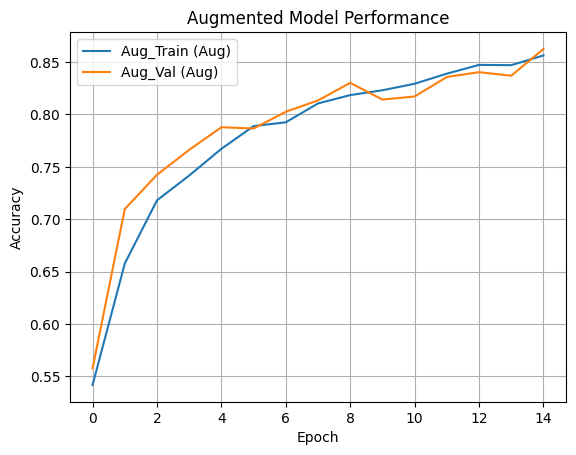

In [34]:
plt.plot(history_aug2.history['accuracy'], label='Aug_Train (Aug)')
plt.plot(history_aug2.history['val_accuracy'], label='Aug_Val (Aug)')
plt.legend()
plt.title("Augmented Model Performance")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

As we can see from the plot, at 15 epoches, the gradient of increase for both training and validation is still relatively sharp, lets continue the training to 20 epoches. 

In [36]:
history_aug2_more = aug_model2.fit(
    train_ds_15k,
    validation_data=val_ds,
    initial_epoch=15,
    epochs=20,
    verbose=1
)

aug_best_val2 = max(history_aug2_more.history['val_accuracy'])
print(f"Baseline best val accuracy: {aug_best_val2:.4f}")


Epoch 16/20


480/480 [==============================] - 36s 55ms/step - loss: 0.3247 - accuracy: 0.8594 - val_loss: 0.3320 - val_accuracy: 0.8526
Epoch 17/20
480/480 [==============================] - 40s 60ms/step - loss: 0.3193 - accuracy: 0.8643 - val_loss: 0.3099 - val_accuracy: 0.8624
Epoch 18/20
480/480 [==============================] - 42s 62ms/step - loss: 0.3091 - accuracy: 0.8672 - val_loss: 0.3088 - val_accuracy: 0.8614
Epoch 19/20
480/480 [==============================] - 43s 65ms/step - loss: 0.3055 - accuracy: 0.8700 - val_loss: 0.3077 - val_accuracy: 0.8658
Epoch 20/20
480/480 [==============================] - 47s 68ms/step - loss: 0.2959 - accuracy: 0.8760 - val_loss: 0.3299 - val_accuracy: 0.8560
Baseline best val accuracy: 0.8658


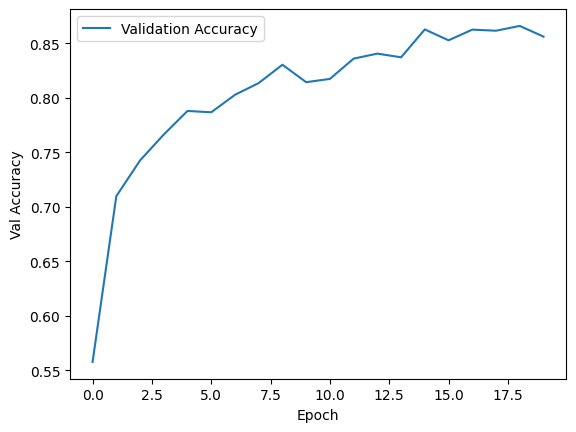

In [67]:
history_aug2_full = {}
for key in history_aug2.history.keys():
    history_aug2_full[key] = history_aug2.history[key] + history_aug2_more.history[key]

# Plot combined learning curve
plt.plot(history_aug2_full['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.legend()
plt.show()


In [68]:
os.makedirs("../deeplearning/models", exist_ok=True)
baseline_model.save("../deeplearning/models/cnn_aug_15k.keras")
print("✅ Model saved successfully!")

✅ Model saved successfully!


We can see some improvement (about 2%) in this new model with image agumentation. Also, the validation loss starts to plateaus and then increase, shows a sign of overfitting, thus the best weights should be obtained at about epoches 17 to 19.

### 2. Next lets adjust the learning rate

learning rate should be large to learn fast initially and decrease later to fit small adjustment rather than jumping over local minima back and forth.
Therefore, adjusting the learning rate dynamically should help, also we can add early stopping too so that we do not have to determine when the validation accuracy plateaus by manually checking the numbers.

EarlyStopping monitors validation accuracy (or loss) and stops training when no improvement is observed for a few epochs.

ReduceLROnPlateau reduces the learning rate when progress slows down, allowing the model to fine-tune its weights more precisely.

Together, they:

1. Speed up convergence
2. Prevent overfitting
3. Automatically handle plateauing validation accuracy

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#  Adaptive Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',   # watch validation accuracy
    factor=0.5,               # reduce LR by half when plateau
    patience=2,               # wait 2 epochs with no improvement
    min_lr=1e-6,              # don't go lower than this
    verbose=1                 # print LR changes
)

#  Early Stopping
early_stop = EarlyStopping(
    monitor='val_accuracy',   # stop when val acc stops improving
    patience=4,               # wait 4 stagnant epochs before stopping
    restore_best_weights=True # revert to best weights, not last ones
)

callbacks = [reduce_lr, early_stop]
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

def build_dlr_model():
    model = models.Sequential([
        layers.Input(shape=(*IMG_SIZE, 3)),          # <-- explicitly define input
        data_augmentation,                            # <- augmentation first

        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

dlr_model = build_dlr_model()
dlr_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 128, 128, 3)       0         
 ial)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                     

In [ ]:
dlr_history = dlr_model.fit( # rename to history_lrs (learning rate scheduling) before final run
    train_ds_15k,
    validation_data=val_ds,
    epochs=30,           # set a high number; early stop will handle it
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
480/480 [==============================] - 61s 92ms/step - loss: 0.6640 - accuracy: 0.6014 - val_loss: 0.6375 - val_accuracy: 0.6318 - lr: 0.0010
Epoch 2/30
480/480 [==============================] - 38s 51ms/step - loss: 0.6053 - accuracy: 0.6732 - val_loss: 0.5902 - val_accuracy: 0.6872 - lr: 0.0010
Epoch 3/30
480/480 [==============================] - 39s 58ms/step - loss: 0.5454 - accuracy: 0.7240 - val_loss: 0.5220 - val_accuracy: 0.7396 - lr: 0.0010
Epoch 4/30
480/480 [==============================] - 35s 53ms/step - loss: 0.5050 - accuracy: 0.7544 - val_loss: 0.5099 - val_accuracy: 0.7488 - lr: 0.0010
Epoch 5/30
480/480 [==============================] - 34s 53ms/step - loss: 0.4872 - accuracy: 0.7670 - val_loss: 0.4388 - val_accuracy: 0.7960 - lr: 0.0010
Epoch 6/30
480/480 [==============================] - 35s 51ms/step - loss: 0.4588 - accuracy: 0.7841 - val_loss: 0.4299 - val_accuracy: 0.7950 - lr: 0.0010
Epoch 7/30
480/480 [==============================] - 41s 

Baseline best val accuracy: 0.8860


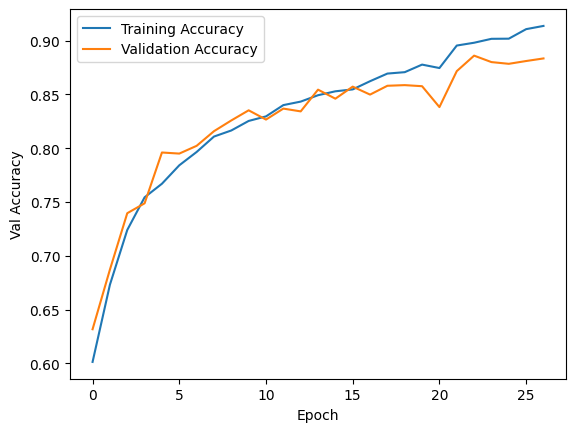

In [ ]:
dlr_best_val = max(dlr_history.history['val_accuracy']) # rename to lrs (learning rate scheduling) before final run
print(f"Baseline best val accuracy: {dlr_best_val:.4f}")

plt.plot(dlr_history.history['accuracy'], label='Training Accuracy')
plt.plot(dlr_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.legend()
plt.show()


In [69]:
os.makedirs("../deeplearning/models", exist_ok=True)
baseline_model.save("../deeplearning/models/cnn_lrs_15k.keras")
print("✅ Model saved successfully!")

✅ Model saved successfully!


We can see that with these changes the validation accuracy increase about 2%

### 3. Final adjustments

In this final model (simple CNN), we made the following adjustments:

1. Batch Normalization:
- Normalizes the output of each layer so that activations have consistent mean and variance across the mini-batch.
- Stabilizes and accelerates training by preventing internal covariate shift.
- Allows the use of slightly higher learning rates without divergence.
- Acts as a mild form of regularization, reducing overfitting.

2. Global Average Pooling (GAP):
- Replaces the traditional Flatten() operation by averaging each feature map (spatially), producing one value per feature channel.
- Dramatically reduces the number of trainable parameters (e.g., from millions to thousands).
- Improves generalization by focusing on whether a feature exists, not where it occurs.
- Reduces overfitting risk while keeping high-level feature abstraction.

2. Add one more dense layer (128 units remained):
- Provide additional non-linear decision boundaries for complex feature combinations.
- Enable the model to “reason” more deeply about the convolutional features before the final output.
- Balanced capacity (128 units × 2) — large enough to learn patterns, small enough to avoid overfitting.

We considered the following options but did not add:
1. LeakyReLU to avoid dead ReLU neuron, not added because Batch normalization already minimise this problem
2. Label smoothing to reduce overconfidence, not added bacause Our task is binary (Cats vs Dogs), where label smoothing often gives negligible or even negative impact.


In [71]:
from tensorflow.keras import layers, models, optimizers, callbacks

def build_final_cnn():
    model = models.Sequential([
        layers.Input(shape=(*IMG_SIZE, 3)),          # <-- explicitly define input
        data_augmentation,                            # <- augmentation first
        # --- Convolutional feature extractor ---
        layers.Conv2D(32, (3,3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), padding='same', activation=None),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), padding='same', activation=None),
        # layers.BatchNormalization(), # removed as BN near output can reduce class separation
        layers.Activation('relu'),
        layers.MaxPooling2D(2,2),

        # --- Global feature summarization ---
        layers.GlobalAveragePooling2D(),

        # --- Fully connected classifier ---
        layers.Dense(256, activation='relu'), # since we reduce model size significantly by using global average pooling, we can afford to increase the dense layer size a bit
        layers.Dropout(0.2), # dropout adjust to 0.2 as we added other regularization methods

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(1, activation='sigmoid')   # binary classification
    ])

    # --- Compile with Adam optimizer + binary crossentropy ---
    optimizer = optimizers.Adam(learning_rate=2e-3) # increase initial learning rate to learn faster
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

final_model = build_final_cnn()
final_model.summary()


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequent  (None, 128, 128, 3)       0         
 ial)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_22 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_24 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                     

In [72]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=4,
    restore_best_weights=True,
    verbose=1
)

callbacks_list = [reduce_lr, early_stop]


In [73]:
history_final = final_model.fit(
    train_ds_15k,
    validation_data=val_ds,
    epochs=40,          # set high; early stop will halt automatically
    callbacks=callbacks_list,
    verbose=1
)


Epoch 1/40
480/480 [==============================] - 36s 52ms/step - loss: 0.6697 - accuracy: 0.5775 - val_loss: 0.7475 - val_accuracy: 0.5388 - lr: 0.0020
Epoch 2/40
480/480 [==============================] - 35s 55ms/step - loss: 0.6464 - accuracy: 0.6156 - val_loss: 0.6610 - val_accuracy: 0.6156 - lr: 0.0020
Epoch 3/40
480/480 [==============================] - 35s 54ms/step - loss: 0.6107 - accuracy: 0.6636 - val_loss: 0.6358 - val_accuracy: 0.6136 - lr: 0.0020
Epoch 4/40
480/480 [==============================] - 38s 55ms/step - loss: 0.5790 - accuracy: 0.6925 - val_loss: 0.6023 - val_accuracy: 0.6552 - lr: 0.0020
Epoch 5/40
480/480 [==============================] - 35s 54ms/step - loss: 0.5620 - accuracy: 0.7059 - val_loss: 0.6967 - val_accuracy: 0.5774 - lr: 0.0020
Epoch 6/40
480/480 [==============================] - 36s 53ms/step - loss: 0.5421 - accuracy: 0.7225 - val_loss: 0.5665 - val_accuracy: 0.6740 - lr: 0.0020
Epoch 7/40
480/480 [==============================] - 39s 

Final Training Accuracy: 0.8522786498069763
Final Validation Accuracy: 0.8258000016212463


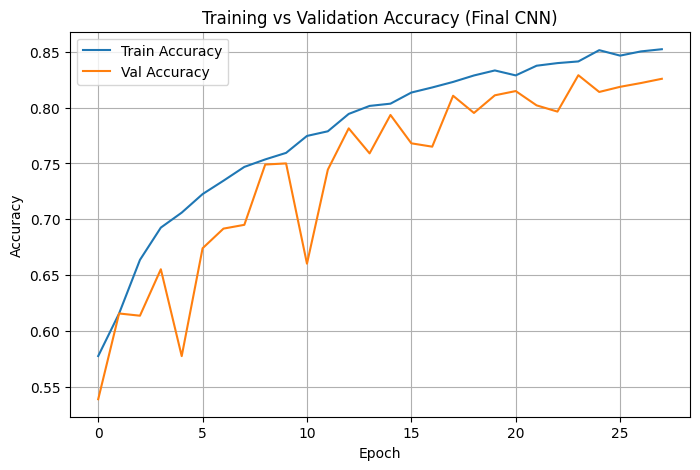

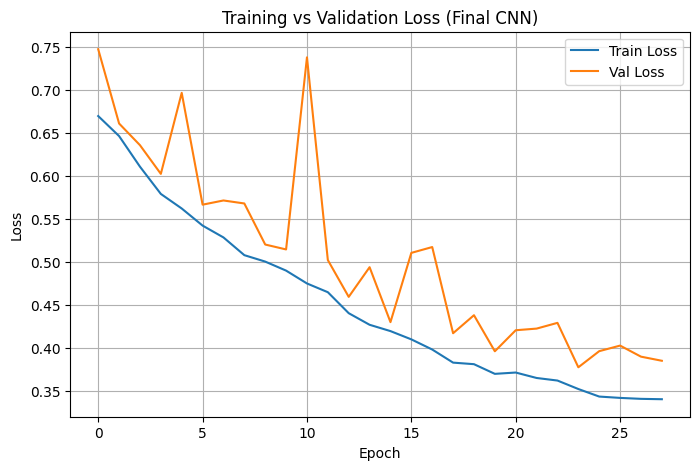

In [74]:
print("Final Training Accuracy:", history_final.history['accuracy'][-1])
print("Final Validation Accuracy:", history_final.history['val_accuracy'][-1])

plt.figure(figsize=(8,5))
plt.plot(history_final.history['accuracy'], label='Train Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (Final CNN)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (Final CNN)')
plt.legend()
plt.grid(True)
plt.show()


In [75]:
os.makedirs("../deeplearning/models", exist_ok=True)
baseline_model.save("../deeplearning/models/cnn_final_15k.keras")
print("✅ Model saved successfully!")

✅ Model saved successfully!
